In [405]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns 


In [406]:

df = pd.read_csv('ctcdata.csv')
df.describe()

,Redshift,Hubble parameter(km/s/Mpc),Error in Hubble Parameter(km/s/Mpc)
count,28.000000,28.000000,28.000000
mean,0.678429,106.978571,18.017857
std,0.558925,42.067559,13.356537
min,0.070000,68.600000,4.000000
25%,0.252500,76.825000,8.000000
50%,0.536500,91.000000,14.000000
75%,0.885000,119.000000,20.750000
max,2.300000,224.000000,62.000000


In [407]:
df.head()


,Redshift,Hubble parameter(km/s/Mpc),Error in Hubble Parameter(km/s/Mpc)
0,0.070,69.0,19.6
1,0.100,69.0,12.0
2,0.120,68.6,26.2
3,0.170,83.0,8.0
4,0.179,75.0,4.0


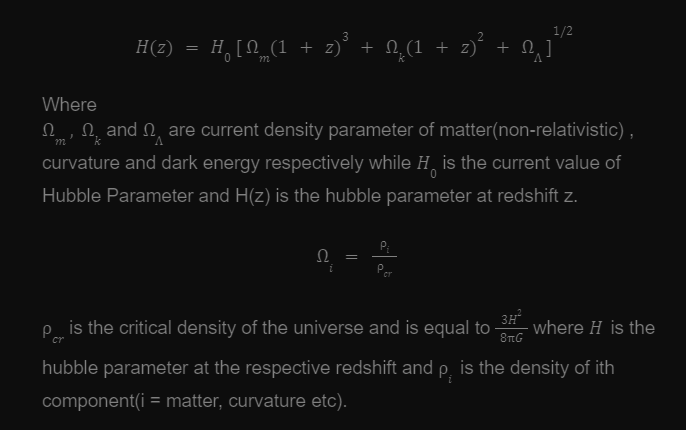

```H(z) = H0 [ Omega_m*(1 + z)**3 + k*(1 + z)**2 + Omega_A ]**0.5```  

H0 =  73.04 +/- 1.04 km s-1Mpc-1  
**Given a dataset for Hubble parameter at various redshifts, constrain and find the best fit values for Omega_m , Omega_k and plot 1 and 2D marginalized probability distributions for all three parameters and report uncertainty corresponding to 1,2 and 3**



In [408]:
h0 =  73.04; e0 = 1.04; h0u = h0 + e0; h0l = h0 - e0 

df.columns = ['z', 'hz', 'e']
df.head()

,z,hz,e
0,0.070,69.0,19.6
1,0.100,69.0,12.0
2,0.120,68.6,26.2
3,0.170,83.0,8.0
4,0.179,75.0,4.0


In [409]:
# df
# tell the 33% and 66% percentile of the data
z33 = df.quantile(0.33)['z']; z66 = df.quantile(0.66)['z']
df.quantile([0.33, 0.66])


,z,hz,e
0.33,0.34370,82.964,11.64
0.66,0.77182,102.794,17.82


```Sqrt( H(z)/H0 ) = A*Omega_m + B*Omega_k + Omega_l```  
```Sqrt( H(z)/H0 ) = a*m + b*k + l```

In [410]:
df['a'] = (1+df['z'])**3
df['b'] = (1+df['z'])**2
df['hz-2'] = ((df['hz']-df['e'])/(h0+e0))**2
df['hz-1'] = ((df['hz']-df['e']*0.5)/(h0-e0))**2
df['hz0'] = ((df['hz']/h0))**2
df['hz1'] = ((df['hz']+df['e']*0.5)/(h0+e0))**2
df['hz2'] = ((df['hz']+df['e'])/(h0-e0))**2
# Add a column of hz1.5 = (hz1+hz2)/2 and hz-1.5 = (hz-1+hz-2)/2
alp = 0.4; bet = 2 - alp
df['hz1.5'] = (alp*df['hz1'] + bet*df['hz2'])/2
df['hz-1.5'] = (0.2*df['hz-1'] + 1.8*df['hz-2'])/2
df['hzu'] = df['hz0'] +1.5*(df['hz2'] - df['hz0'])
df['hzl'] = df['hz0'] -1.5*(df['hz0'] - df['hz-2'])
df.head()

,z,hz,e,a,b,hz-2,hz-1,hz0,hz1,hz2,hz1.5,hz-1.5,hzu,hzl
0,0.070,69.0,19.6,1.225043,1.144900,0.444684,0.676049,0.892435,1.131489,1.514267,1.437711,0.467821,1.825183,0.220809
1,0.100,69.0,12.0,1.331000,1.210000,0.592036,0.765625,0.892435,1.024992,1.265625,1.217498,0.609394,1.452220,0.441836
2,0.120,68.6,26.2,1.404928,1.254400,0.327589,0.594184,0.882118,1.216304,1.733611,1.630150,0.354249,2.159358,0.050325
3,0.170,83.0,8.0,1.601613,1.368900,1.024992,1.203897,1.291322,1.379230,1.597415,1.553778,1.042883,1.750462,0.891827
4,0.179,75.0,4.0,1.638858,1.390041,0.918575,1.027971,1.054389,1.080387,1.203897,1.179195,0.929515,1.278650,0.850668


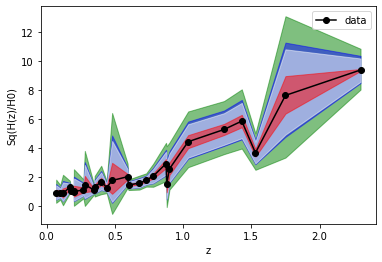

In [411]:
# H(z) = H0 [ Omega_m*(1 + z)**3 + k*(1 + z)**2 + Omega_A ]**0.5
# H0 =  73.04 +/- 1.04 km s-1Mpc-1 

# Thus, we can write the equation as:
#  Omega_m*(1 + z)**3 + k*(1 + z)**2 + Omega_A = (H(z)/H0)**2
## Sq( H(z)/H0 ) = A*Omega_m + B*Omega_k + Omega_l  
## Sq( H(z)/H0 ) = a*m + b*k + l

# hz-2 is the lower error bar
# hz+2 is the upper error bar
# hz0 is the central value
# a = (1+z)**3
# b = (1+z)**2
# l = Omega_l
# m = Omega_m
# k = Omega_k

def model(z, m, k, l):
    return (m*(1+z)**3 + k*(1+z)**2 + l)

def chi2(m, k, l):
    return np.sum((df['hz0'] - model(df['z'], m, k, l))**2)

def plot_tolerances(m, k, l):
    plt.plot(df['z'], df['hz0'], 'o', label='data')
    z = np.linspace(0, 2, 100)
    plt.plot(z, model(z, m, k, l), label='best fit model')
    plt.fill_between(df['z'], df['hzl'], df['hzu'], color='gray', alpha=0.5)
    plt.xlabel('z')
    plt.ylabel('H(z)/H0')
    plt.legend()
    plt.show()

def tolerance_boundaries():
    plt.plot(df['z'], df['hz0'], 'o-', color='black', label='data')
    z = np.linspace(0, 2, 100)
    # plt.plot(z, model(z, 0.3, 0, 0.7), label='best fit model')
    plt.fill_between(df['z'], df['hzl'], df['hzu'], color='green', alpha=0.5)
    plt.fill_between(df['z'], df['hz-2'], df['hz2'], color='blue', alpha=0.5)
    plt.fill_between(df['z'], df['hz-1.5'], df['hz1.5'], color='white', alpha=0.5)
    plt.fill_between(df['z'], df['hz-1'], df['hz1'], color='red', alpha=0.5)
    plt.xlabel('z')
    plt.ylabel('Sq(H(z)/H0)')
    plt.legend()
    plt.show()

tolerance_boundaries()


Find the initial value of the parameters. Choose 3 rows from the data with minimum error and calculate the value of m, k, and l by solving the 3 linear equations.  
```Sq(H(z)/H0) = a*m + b*k + l```  
```Sq(H(z)/H0) = a1*m + b1*k + l```  
```Sq(H(z)/H0) = a2*m + b2*k + l```  

```m = (a1*b2 - a2*b1)/(a*b2 - a2*b)```  
```k = (a*b1 - a1*b)/(a*b2 - a2*b)```  
```l = (a1*b - a*b1)/(a*b2 - a2*b)```  

```a = Sq(H(z1)/H0)```  
```b = Sq(H(z2)/H0)```  
```a1 = Sq(H(z3)/H0)```  
```b1 = (1+z1)**2```  
```a2 = (1+z2)**2```  
```b2 = (1+z3)**2```  
  
Thus  
```m = (a1*(1+z3)**2 - (1+z2)**2*Sq(H(z3)/H0))/(Sq(H(z1)/H0)*(1+z3)**2 - (1+z2)**2*Sq(H(z1)/H0))```  
```k = (Sq(H(z1)/H0)*(1+z3)**2 - a1*(1+z2)**2)/(Sq(H(z1)/H0)*(1+z3)**2 - (1+z2)**2*Sq(H(z1)/H0))```  
```l = (a1*(1+z2)**2*Sq(H(z1)/H0) - Sq(H(z1)/H0)*(1+z2)**2*Sq(H(z3)/H0))/(Sq(H(z1)/H0)*(1+z3)**2 - (1+z2)**2*Sq(H(z1)/H0))```  


In [412]:
_ = '''```Sq(H(z)/H0) = a*m + b*k + l```  
```Sq(H(z)/H0) = a1*m + b1*k + l```   
```Sq(H(z)/H0) = a2*m + b2*k + l```   
  '''
df.sort_values(by='e').head() 
# 4,5, 9 are the lowest errors 


,z,hz,e,a,b,hz-2,hz-1,hz0,hz1,hz2,hz1.5,hz-1.5,hzu,hzl
4,0.179,75.0,4.0,1.638858,1.390041,0.918575,1.027971,1.054389,1.080387,1.203897,1.179195,0.929515,1.278650,0.850668
5,0.199,75.0,5.0,1.723684,1.437601,0.892882,1.013937,1.054389,1.094464,1.234568,1.206547,0.904988,1.324657,0.812129
9,0.350,76.3,5.6,2.460375,1.822500,0.910829,1.042101,1.091258,1.140121,1.293906,1.263149,0.923956,1.395230,0.820614
15,0.600,87.9,6.1,4.096000,2.560000,1.219283,1.388797,1.448292,1.507313,1.704475,1.665043,1.236235,1.832567,1.104779
17,0.730,97.3,7.0,5.177717,2.992900,1.485845,1.697230,1.774615,1.851480,2.098474,2.049075,1.506984,2.260404,1.341460


In [413]:

m = (df['a'].iloc[5]*df['b'].iloc[9] - df['a'].iloc[9]*df['b'].iloc[5])/(df['a'].iloc[4]*df['b'].iloc[9] - df['a'].iloc[9]*df['b'].iloc[4])
k = (df['a'].iloc[4]*df['b'].iloc[9] - df['a'].iloc[5]*df['b'].iloc[4])/(df['a'].iloc[4]*df['b'].iloc[9] - df['a'].iloc[9]*df['b'].iloc[4])
l = (df['a'].iloc[5]*df['b'].iloc[4]*df['hz0'].iloc[4] - df['a'].iloc[4]*df['b'].iloc[5]*df['hz0'].iloc[5])/(df['a'].iloc[4]*df['b'].iloc[9] - df['a'].iloc[9]*df['b'].iloc[4])

print(m, k, l)



0.9132540206826573 -1.3638610962706268 -0.09727600182599916


X_matrix: [ 0.73432639 -1.309702    1.67147187]


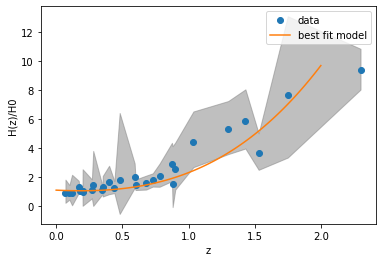

In [414]:

# Y_matrix = np.array([df['hz0'].iloc[4], df['hz0'].iloc[5], df['hz0'].iloc[9]]).T
# # Y = MX
# M_matrix = np.array([   [df['a'].iloc[4], df['b'].iloc[4], 1], 
#                         [df['a'].iloc[5], df['b'].iloc[5], 1], 
#                         [df['a'].iloc[9], df['b'].iloc[9], 1]])

# X = np.linalg.solve(M_matrix, Y_matrix)
# print(X)
def solve_rows(row1, row2, row3):
    Y_matrix = np.array([df['hz0'].iloc[row1], df['hz0'].iloc[row2], df['hz0'].iloc[row3]]).T
    M_matrix = np.array([   [df['a'].iloc[row1], df['b'].iloc[row1], 1], 
                            [df['a'].iloc[row2], df['b'].iloc[row2], 1], 
                            [df['a'].iloc[row3], df['b'].iloc[row3], 1]])
    X = np.linalg.solve(M_matrix, Y_matrix)
    return X
    # yield X
    # Y_confirm = np.matmul(M_matrix, X)
    # yield np.allclose(Y_matrix, Y_confirm)
f = solve_rows(4, 5, 9)
X = f
print(f'X_matrix: {X}')
# print(X)
# print(next(f))
plot_tolerances(*X)
# print(f'Y_matrix: {Y_matrix}')
# print(f'Y_confirm: {Y_confirm}')
# print(np.allclose(Y_matrix, Y_confirm))

X: [ 0.73432639 -1.309702    1.67147187]
Initial loss_ul: 3.323131799127675
0) Best fit values of m, k, and l:[0.11421142 0.51033167 0.23751755]
1) Best fit values of m, k, and l:[0.09722551 0.54323476 0.06524422]
1.5) Best fit values of m, k, and l:[ 0.0189713   0.73786674 -0.13693109]
2) Best fit values of m, k, and l:[0.20361549 0.25047957 0.28399507]
               m      k      l  Var_m  Var_k  Var_l  Loss_0  Loss_1  Loss_1_5  \
Loss used                                                                       
Loss_0     0.114  0.510  0.238  0.065  0.461  0.303  12.674   6.862     1.316   
Loss_1     0.097  0.543  0.065  0.002  0.014  0.013  11.796   5.995     0.701   
Loss_1_5   0.019  0.738 -0.137  0.017  0.228  0.583  13.394   7.302     0.575   
Loss_2     0.204  0.250  0.284  0.013  0.200  0.459  12.265   6.516     0.788   

           Loss_2  Loss_U_L  
Loss used                    
Loss_0      1.849     0.776  
Loss_1      1.143     0.113  
Loss_1_5    1.202     0.000  
Loss_2

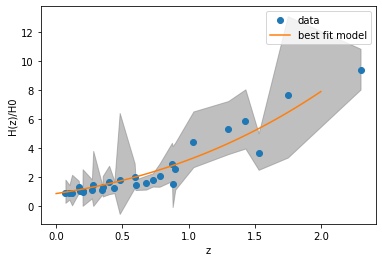

For loss_1


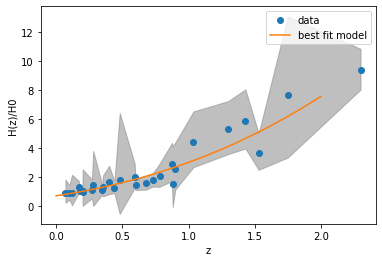

For loss_1.5


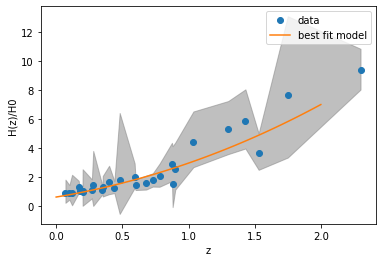

For loss_2


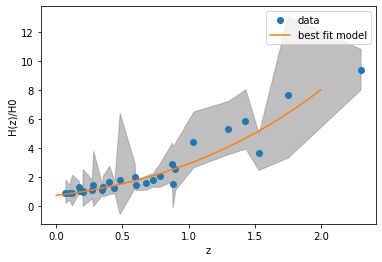

,m,k,l,Var_m,Var_k,Var_l,Loss_0,Loss_1,Loss_1_5,Loss_2,Loss_U_L
Loss used,,,,,,,,,,,
Loss_0,0.114,0.510,0.238,0.065,0.461,0.303,12.674,6.862,1.316,1.849,0.776
Loss_1,0.097,0.543,0.065,0.002,0.014,0.013,11.796,5.995,0.701,1.143,0.113
Loss_1_5,0.019,0.738,-0.137,0.017,0.228,0.583,13.394,7.302,0.575,1.202,0.000
Loss_2,0.204,0.250,0.284,0.013,0.200,0.459,12.265,6.516,0.788,1.060,0.159


In [415]:
X = solve_rows(4, 5, 9)
# Now initialize the parameters with the values of m, k, and l, define loss function and use gradient descent to minimize the loss function
def loss_0(params):
    m, k, l = params
    v = model(df['z'], m, k, l)
    loss = np.zeros(len(v))
    # print(f'len(v): {len(v)}')
    for i in range(len(v)):
        loss[i] = abs(v[i] - df['hz0'][i])
    return np.sum(loss) 

def loss_1(params):
    m, k, l = params
    v = model(df['z'], m, k, l)
    loss = np.zeros(len(v))
    # print(f'len(v): {len(v)}')
    for i in range(len(v)):
        if v[i] > df['hz1'][i]:
            loss[i] = (v[i] - df['hz1'][i])
        elif v[i] < df['hz-1'][i]:
            loss[i] = (df['hz-1'][i] - v[i])
        else:
            loss[i] = 0
    return np.sum(loss)

def loss_1_5(params):
    m, k, l = params
    v = model(df['z'], m, k, l)
    loss = np.zeros(len(v))
    # print(f'len(v): {len(v)}')
    for i in range(len(v)):
        if v[i] > df['hz1.5'][i]:
            loss[i] = (v[i] - df['hz1.5'][i])**1.8
        elif v[i] < df['hz-1.5'][i]:
            loss[i] = (df['hz-1.5'][i] - v[i])**1.8
        else:
            loss[i] = 0
    return np.sum(loss)

def loss_2(params):
    m, k, l = params
    v = model(df['z'], m, k, l)
    loss = np.zeros(len(v))
    # print(f'len(v): {len(v)}')
    for i in range(len(v)):
        if v[i] > df['hz2'][i]:
            loss[i] = (v[i] - df['hz2'][i])
        elif v[i] < df['hz-2'][i]:
            loss[i] = (df['hz-2'][i] - v[i])
        else:
            loss[i] = 0
    return np.sum(loss)

def loss_ul(params):
    m, k, l = params
    v = model(df['z'], m, k, l)
    loss = np.zeros(len(v))
    # print(f'len(v): {len(v)}')
    for i in range(len(v)):
        if v[i] > df['hzu'][i]:
            loss[i] = (v[i] - df['hzu'][i])
        elif v[i] < df['hzl'][i]:
            loss[i] = (df['hzl'][i] - v[i])
        else:
            loss[i] = 0
    return np.sum(loss)

from scipy.optimize import minimize
def fit_values(X):
    print(f'X: {X}')
    print(f'Initial loss_ul: {loss_ul(X)}')
    result_0 = minimize(loss_0, X)
    # Report the variance of the parameters
    print(f'0) Best fit values of m, k, and l:{result_0.x}')
    # print(f'Loss_0 = {loss_0(result_0.x)};\n Loss_1 = {loss_1(result_0.x)};\n loss_1_5 = {loss_1_5(result_0.x)};\n Loss_2 = {loss_2(result_0.x)}')
    # print(f'Variance of m: {result_0.hess_inv[0,0]}, Variance of k = {result_0.hess_inv[1,1]}, Variance of l = {result_0.hess_inv[2,2]}\n')

    result_1 = minimize(loss_1, X)
    print(f'1) Best fit values of m, k, and l:{result_1.x}')
    # print(f'Loss_0 = {loss_0(result_1.x)};\n Loss_1 = {loss_1(result_1.x)};\n loss_1_5 = {loss_1_5(result_1.x)};\n Loss_2 = {loss_2(result_1.x)}')
    # print(f'Variance of m: {result_1.hess_inv[0,0]}, Variance of k = {result_1.hess_inv[1,1]}, Variance of l = {result_1.hess_inv[2,2]}\n')

    result_1_5 = minimize(loss_1_5, X)
    print(f'1.5) Best fit values of m, k, and l:{result_1_5.x}')
    # print(f'Loss_0 = {loss_0(result_1_5.x)};\n Loss_1 = {loss_1(result_1_5.x)};\n loss_1_5 = {loss_1_5(result_1_5.x)};\n Loss_2 = {loss_2(result_1_5.x)}')
    # print(f'Variance of m: {result_1_5.hess_inv[0,0]}, Variance of k = {result_1_5.hess_inv[1,1]}, Variance of l = {result_1_5.hess_inv[2,2]}\n')

    result_2 = minimize(loss_2, X)
    print(f'2) Best fit values of m, k, and l:{result_2.x}')
    # print(f'Loss_0 = {loss_0(result_2.x)};\n Loss_1 = {loss_1(result_2.x)};\n loss_1_5 = {loss_1_5(result_2.x)};\n Loss_2 = {loss_2(result_2.x)}')
    # print(f'Variance of m: {result_2.hess_inv[0,0]}, Variance of k = {result_2.hess_inv[1,1]}, Variance of l = {result_2.hess_inv[2,2]}\n')


    # Tabulate the results using dataframes
    # Rows: Loss_0, Loss_1, Loss_1_5, Loss_2
    # Columns: Best fit values of m, k, and l; Loss_0, Loss_1, Loss_1_5, Loss_2; Variance of m, k, and l, Everything rounded to 3 decimal places
    df_results = pd.DataFrame({'m':[result_0.x[0], result_1.x[0], result_1_5.x[0], result_2.x[0]],
                        'k':[result_0.x[1], result_1.x[1], result_1_5.x[1], result_2.x[1]],
                        'l':[result_0.x[2], result_1.x[2], result_1_5.x[2], result_2.x[2]],
                        'Var_m':[result_0.hess_inv[0,0], result_1.hess_inv[0,0], result_1_5.hess_inv[0,0], result_2.hess_inv[0,0]],
                        'Var_k':[result_0.hess_inv[1,1], result_1.hess_inv[1,1], result_1_5.hess_inv[1,1], result_2.hess_inv[1,1]],
                        'Var_l':[result_0.hess_inv[2,2], result_1.hess_inv[2,2], result_1_5.hess_inv[2,2], result_2.hess_inv[2,2]],
                        'Loss_0':[loss_0(result_0.x), loss_0(result_1.x), loss_0(result_1_5.x), loss_0(result_2.x)], 
                        'Loss_1':[loss_1(result_0.x), loss_1(result_1.x), loss_1(result_1_5.x), loss_1(result_2.x)], 
                        'Loss_1_5':[loss_1_5(result_0.x), loss_1_5(result_1.x), loss_1_5(result_1_5.x), loss_1_5(result_2.x)], 
                        'Loss_2':[loss_2(result_0.x), loss_2(result_1.x), loss_2(result_1_5.x), loss_2(result_2.x)], 
                        'Loss_U_L':[loss_ul(result_0.x), loss_ul(result_1.x), loss_ul(result_1_5.x), loss_ul(result_2.x)]
                        })
    #THE last column must be hilighted
    df_results = df_results.round(3)
    df_results.style.highlight_max(color = 'lightgreen', axis = 0)
    df_results.index = ['Loss_0', 'Loss_1', 'Loss_1_5', 'Loss_2']
    # The origin cell must say - 'Method'
    df_results.index.name = 'Loss used'

    # print(df_results)
    df_results.to_csv('results_1.csv')
    # Show df_results
    print(df_results)
    
    print('For loss_0')
    plot_tolerances(result_0.x[0], result_0.x[1], result_0.x[2])
    print('For loss_1')
    plot_tolerances(result_1.x[0], result_1.x[1], result_1.x[2])
    print('For loss_1.5')
    plot_tolerances(result_1_5.x[0], result_1_5.x[1], result_1_5.x[2])
    print('For loss_2')
    plot_tolerances(result_2.x[0], result_2.x[1], result_2.x[2])
    return df_results

fit_values(X)

X: [-0.15290457  1.32031415 -0.70495437]
Initial loss_ul: 0.8860147723884455
0) Best fit values of m, k, and l:[0.0931772  0.54631973 0.10740908]
1) Best fit values of m, k, and l:[0.0962086  0.54681136 0.06034362]
1.5) Best fit values of m, k, and l:[ 0.01897156  0.73786595 -0.13693053]
2) Best fit values of m, k, and l:[ 0.01139665  0.78627134 -0.19965811]
               m      k      l  Var_m  Var_k  Var_l  Loss_0  Loss_1  Loss_1_5  \
Loss used                                                                       
Loss_0     0.093  0.546  0.107  0.024  0.118  0.047  11.744   6.081     0.727   
Loss_1     0.096  0.547  0.060  0.018  0.174  0.195  11.797   5.994     0.702   
Loss_1_5   0.019  0.738 -0.137  0.019  0.253  0.617  13.394   7.302     0.575   
Loss_2     0.011  0.786 -0.200  0.000  0.000  0.000  13.137   6.991     0.626   

           Loss_2  Loss_U_L  
Loss used                    
Loss_0      1.203     0.143  
Loss_1      1.144     0.115  
Loss_1_5    1.202     0.000  
Lo

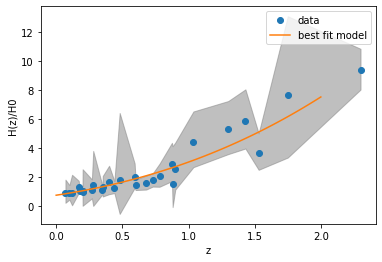

For loss_1


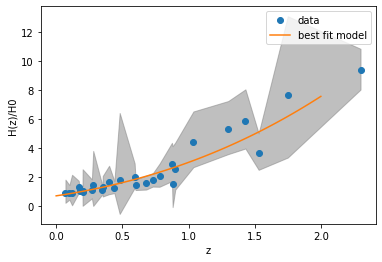

For loss_1.5


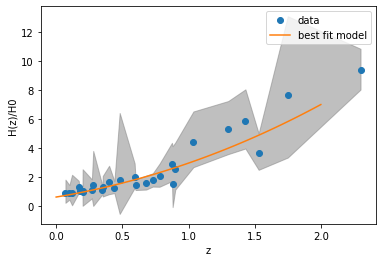

For loss_2


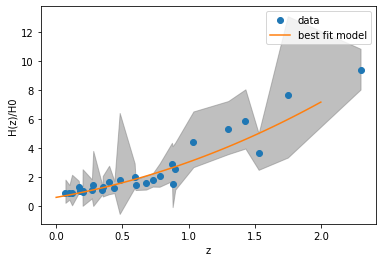

,m,k,l,Var_m,Var_k,Var_l,Loss_0,Loss_1,Loss_1_5,Loss_2,Loss_U_L
Loss used,,,,,,,,,,,
Loss_0,0.093,0.546,0.107,0.024,0.118,0.047,11.744,6.081,0.727,1.203,0.143
Loss_1,0.096,0.547,0.060,0.018,0.174,0.195,11.797,5.994,0.702,1.144,0.115
Loss_1_5,0.019,0.738,-0.137,0.019,0.253,0.617,13.394,7.302,0.575,1.202,0.000
Loss_2,0.011,0.786,-0.200,0.000,0.000,0.000,13.137,6.991,0.626,1.163,0.027


In [416]:
# 7, 14, 19
X = solve_rows(7, 14, 19)

# Now initialize the parameters with the values of m, k, and l, define loss function and use gradient descent to minimize the loss function
def loss_0(params):
    m, k, l = params
    v = model(df['z'], m, k, l)
    loss = np.zeros(len(v))
    # print(f'len(v): {len(v)}')
    for i in range(len(v)):
        loss[i] = abs(v[i] - df['hz0'][i])
    return np.sum(loss) 

def loss_1(params):
    m, k, l = params
    v = model(df['z'], m, k, l)
    loss = np.zeros(len(v))
    # print(f'len(v): {len(v)}')
    for i in range(len(v)):
        if v[i] > df['hz1'][i]:
            loss[i] = (v[i] - df['hz1'][i])
        elif v[i] < df['hz-1'][i]:
            loss[i] = (df['hz-1'][i] - v[i])
        else:
            loss[i] = 0
    return np.sum(loss)

def loss_1_5(params):
    m, k, l = params
    v = model(df['z'], m, k, l)
    loss = np.zeros(len(v))
    # print(f'len(v): {len(v)}')
    for i in range(len(v)):
        if v[i] > df['hz1.5'][i]:
            loss[i] = (v[i] - df['hz1.5'][i])**1.8
        elif v[i] < df['hz-1.5'][i]:
            loss[i] = (df['hz-1.5'][i] - v[i])**1.8
        else:
            loss[i] = 0
    return np.sum(loss)

def loss_2(params):
    m, k, l = params
    v = model(df['z'], m, k, l)
    loss = np.zeros(len(v))
    # print(f'len(v): {len(v)}')
    for i in range(len(v)):
        if v[i] > df['hz2'][i]:
            loss[i] = (v[i] - df['hz2'][i])
        elif v[i] < df['hz-2'][i]:
            loss[i] = (df['hz-2'][i] - v[i])
        else:
            loss[i] = 0
    return np.sum(loss)

def loss_ul(params):
    m, k, l = params
    v = model(df['z'], m, k, l)
    loss = np.zeros(len(v))
    # print(f'len(v): {len(v)}')
    for i in range(len(v)):
        if v[i] > df['hzu'][i]:
            loss[i] = (v[i] - df['hzu'][i])
        elif v[i] < df['hzl'][i]:
            loss[i] = (df['hzl'][i] - v[i])
        else:
            loss[i] = 0
    return np.sum(loss)

from scipy.optimize import minimize
def fit_values(X):
    print(f'X: {X}')
    print(f'Initial loss_ul: {loss_ul(X)}')
    result_0 = minimize(loss_0, X)
    # Report the variance of the parameters
    print(f'0) Best fit values of m, k, and l:{result_0.x}')
    # print(f'Loss_0 = {loss_0(result_0.x)};\n Loss_1 = {loss_1(result_0.x)};\n loss_1_5 = {loss_1_5(result_0.x)};\n Loss_2 = {loss_2(result_0.x)}')
    # print(f'Variance of m: {result_0.hess_inv[0,0]}, Variance of k = {result_0.hess_inv[1,1]}, Variance of l = {result_0.hess_inv[2,2]}\n')

    result_1 = minimize(loss_1, X)
    print(f'1) Best fit values of m, k, and l:{result_1.x}')
    # print(f'Loss_0 = {loss_0(result_1.x)};\n Loss_1 = {loss_1(result_1.x)};\n loss_1_5 = {loss_1_5(result_1.x)};\n Loss_2 = {loss_2(result_1.x)}')
    # print(f'Variance of m: {result_1.hess_inv[0,0]}, Variance of k = {result_1.hess_inv[1,1]}, Variance of l = {result_1.hess_inv[2,2]}\n')

    result_1_5 = minimize(loss_1_5, X)
    print(f'1.5) Best fit values of m, k, and l:{result_1_5.x}')
    # print(f'Loss_0 = {loss_0(result_1_5.x)};\n Loss_1 = {loss_1(result_1_5.x)};\n loss_1_5 = {loss_1_5(result_1_5.x)};\n Loss_2 = {loss_2(result_1_5.x)}')
    # print(f'Variance of m: {result_1_5.hess_inv[0,0]}, Variance of k = {result_1_5.hess_inv[1,1]}, Variance of l = {result_1_5.hess_inv[2,2]}\n')

    result_2 = minimize(loss_2, X)
    print(f'2) Best fit values of m, k, and l:{result_2.x}')
    # print(f'Loss_0 = {loss_0(result_2.x)};\n Loss_1 = {loss_1(result_2.x)};\n loss_1_5 = {loss_1_5(result_2.x)};\n Loss_2 = {loss_2(result_2.x)}')
    # print(f'Variance of m: {result_2.hess_inv[0,0]}, Variance of k = {result_2.hess_inv[1,1]}, Variance of l = {result_2.hess_inv[2,2]}\n')


    # Tabulate the results using dataframes
    # Rows: Loss_0, Loss_1, Loss_1_5, Loss_2
    # Columns: Best fit values of m, k, and l; Loss_0, Loss_1, Loss_1_5, Loss_2; Variance of m, k, and l, Everything rounded to 3 decimal places
    df_results = pd.DataFrame({'m':[result_0.x[0], result_1.x[0], result_1_5.x[0], result_2.x[0]],
                        'k':[result_0.x[1], result_1.x[1], result_1_5.x[1], result_2.x[1]],
                        'l':[result_0.x[2], result_1.x[2], result_1_5.x[2], result_2.x[2]],
                        'Var_m':[result_0.hess_inv[0,0], result_1.hess_inv[0,0], result_1_5.hess_inv[0,0], result_2.hess_inv[0,0]],
                        'Var_k':[result_0.hess_inv[1,1], result_1.hess_inv[1,1], result_1_5.hess_inv[1,1], result_2.hess_inv[1,1]],
                        'Var_l':[result_0.hess_inv[2,2], result_1.hess_inv[2,2], result_1_5.hess_inv[2,2], result_2.hess_inv[2,2]],
                        'Loss_0':[loss_0(result_0.x), loss_0(result_1.x), loss_0(result_1_5.x), loss_0(result_2.x)], 
                        'Loss_1':[loss_1(result_0.x), loss_1(result_1.x), loss_1(result_1_5.x), loss_1(result_2.x)], 
                        'Loss_1_5':[loss_1_5(result_0.x), loss_1_5(result_1.x), loss_1_5(result_1_5.x), loss_1_5(result_2.x)], 
                        'Loss_2':[loss_2(result_0.x), loss_2(result_1.x), loss_2(result_1_5.x), loss_2(result_2.x)], 
                        'Loss_U_L':[loss_ul(result_0.x), loss_ul(result_1.x), loss_ul(result_1_5.x), loss_ul(result_2.x)]
                        })
    #THE last column must be hilighted
    df_results = df_results.round(3)
    df_results.style.highlight_max(color = 'lightgreen', axis = 0)
    df_results.index = ['Loss_0', 'Loss_1', 'Loss_1_5', 'Loss_2']
    # The origin cell must say - 'Method'
    df_results.index.name = 'Loss used'

    # print(df_results)
    df_results.to_csv('results_2.csv')
    # Show df_results
    print(df_results)
    
    print('For loss_0')
    plot_tolerances(result_0.x[0], result_0.x[1], result_0.x[2])
    print('For loss_1')
    plot_tolerances(result_1.x[0], result_1.x[1], result_1.x[2])
    print('For loss_1.5')
    plot_tolerances(result_1_5.x[0], result_1_5.x[1], result_1_5.x[2])
    print('For loss_2')
    plot_tolerances(result_2.x[0], result_2.x[1], result_2.x[2])
    return df_results

fit_values(X)

Plot:


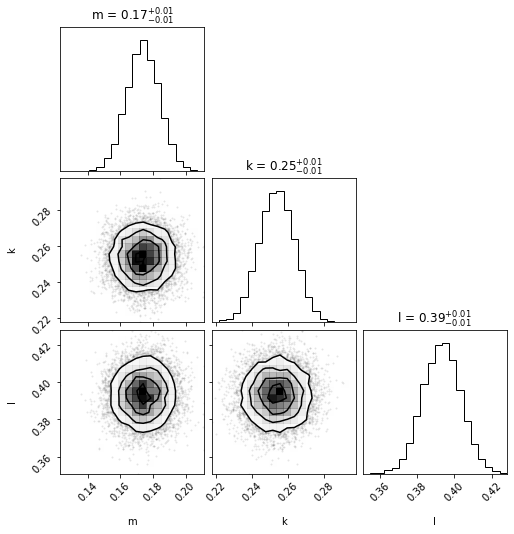

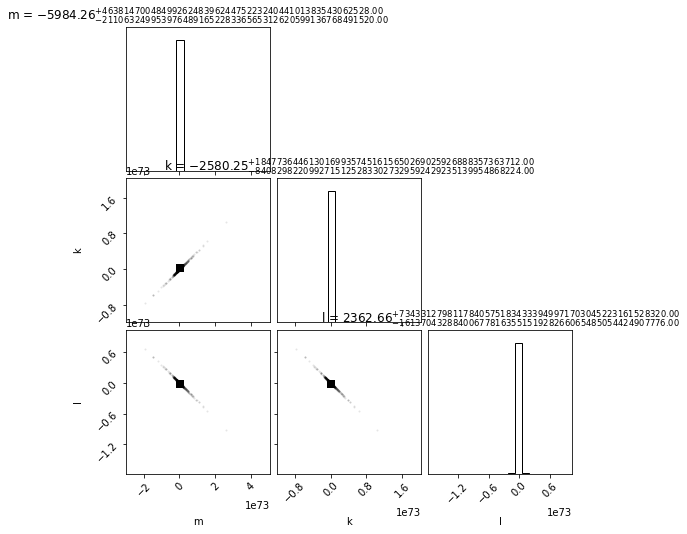

In [439]:
# Best fit values of m, k, and l:[0.17394948 0.25353387 0.39313364]
# plot 1 and 2D marginalized probability distributions for all three parameters and report uncertainty corresponding to 1,2 and 3 

m, k, l = 0.17394948, 0.25353387, 0.39313364

# Plot 1D marginalized probability distributions for all three parameters
import corner



def plot_1D_marginalized():
    samples = np.random.normal([m, k, l], np.sqrt(0.0001), [10000, 3])
    fig = corner.corner(samples, labels=['m', 'k', 'l'], show_titles=True)
    plt.show()

plot_1D_marginalized()

# Plot 2D marginalized probability distributions for all three parameters
import emcee
# Report uncertainty corresponding to 1,2 and 3 sigma
def chi2(params):
    m, k, l = params
    # calculate chi2 value
    # return chi2 value
    return np.sum((df['hz0'] - model(df['z'], m, k, l))**2)

def plot_2D_marginalized():
    # using emcee
    ndim, nwalkers = 3, 100
    pos = [np.array([m, k, l]) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

    sampler = emcee.EnsembleSampler(nwalkers, ndim, chi2)
    sampler.run_mcmc(pos, 500)
    samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
    fig = corner.corner(samples, labels=['m', 'k', 'l'], show_titles=True)
    plt.show()

plot_2D_marginalized()





def report_uncertainty():
    # using emcee
    ndim, nwalkers = 3, 100
    pos = [np.array([m, k, l]) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, chi2)
    sampler.run_mcmc(pos, 500)
    samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
    print(f'1 sigma uncertainty for m: {np.percentile(samples[:,0], [16, 84])}')
    print(f'1 sigma uncertainty for k: {np.percentile(samples[:,1], [16, 84])}')
    print(f'1 sigma uncertainty for l: {np.percentile(samples[:,2], [16, 84])}')
    print(f'2 sigma uncertainty for m, k, l: {np.percentile(samples, [2.5, 97.5], axis=0)}')
    print(f'3 sigma uncertainty for m, k, l: {np.percentile(samples, [0.15, 99.85], axis=0)}')

# import corner

# def plot_2D_marginalized():
#     samples = np.random.normal([m, k, l], np.sqrt(0.0001), [10000, 3])
#     fig = corner.corner(samples, labels=['m', 'k', 'l'], show_titles=True)
#     plt.show()

# plot_2D_marginalized()

# # Report uncertainty corresponding to 1,2 and 3 sigma
# def report_uncertainty():
#     print(f'1 sigma uncertainty for m: {np.percentile(np.random.normal(m, np.sqrt(0.0001), 10000), [16, 84])}')
#     print(f'1 sigma uncertainty for k: {np.percentile(np.random.normal(k, np.sqrt(0.0001), 10000), [16, 84])}')
#     print(f'1 sigma uncertainty for l: {np.percentile(np.random.normal(l, np.sqrt(0.0001), 10000), [16, 84])}')
#     print(f'2 sigma uncertainty for m: {np.percentile(np.random.normal(m, np.sqrt(0.0001), 10000), [2.5, 97.5])}')
#     print(f'2 sigma uncertainty for k: {np.percentile(np.random.normal(k, np.sqrt(0.0001), 10000), [2.5, 97.5])}')
#     print(f'2 sigma uncertainty for l: {np.percentile(np.random.normal(l, np.sqrt(0.0001), 10000), [2.5, 97.5])}')
#     print(f'3 sigma uncertainty for m: {np.percentile(np.random.normal(m, np.sqrt(0.0001), 10000), [0.15, 99.85])}')
#     print(f'3 sigma uncertainty for k: {np.percentile(np.random.normal(k, np.sqrt(0.0001), 10000), [0.15, 99.85])}')
#     print(f'3 sigma uncertainty for l: {np.percentile(np.random.normal(l, np.sqrt(0.0001), 10000), [0.15, 99.85])}')
# # def plot_1D_marginalized():
# #     plt.hist(np.random.normal(m, np.sqrt(0.0001), 10000), bins=100, label='m')
# #     plt.hist(np.random.normal(k, np.sqrt(0.0001), 10000), bins=100, label='k')
# #     plt.hist(np.random.normal(l, np.sqrt(0.0001), 10000), bins=100, label='l')
# #     plt.xlabel('Parameter values')
# #     plt.ylabel('Frequency')
# #     plt.legend()
# #     plt.show()
# # plot_1D_marginalized()

# # # Plot 2D marginalized probability distributions for all three parameters
# # def plot_2D_marginalized():
# #     plt.hist2d(np.random.normal(m, np.sqrt(0.0001), 10000), np.random.normal(k, np.sqrt(0.0001), 10000), bins=100, label='m vs k')
# #     plt.xlabel('m')
# #     plt.ylabel('k')
# #     # plt.legend()
# #     plt.show()

# #     plt.hist2d(np.random.normal(m, np.sqrt(0.0001), 10000), np.random.normal(l, np.sqrt(0.0001), 10000), bins=100, label='m vs l')
# #     plt.xlabel('m')
# #     plt.ylabel('l')
# #     # plt.legend()
# #     plt.show()

# #     plt.hist2d(np.random.normal(k, np.sqrt(0.0001), 10000), np.random.normal(l, np.sqrt(0.0001), 10000), bins=100, label='k vs l')
# #     plt.xlabel('k')
# #     plt.ylabel('l')
# #     # plt.legend()
# #     plt.show()
# # plot_2D_marginalized()

# # # Report uncertainty corresponding to 1,2 and 3 sigma
# # def report_uncertainty():
# #     print(f'1 sigma uncertainty for m: {np.percentile(np.random.normal(m, np.sqrt(0.0001), 10000), [16, 84])}')
# #     print(f'1 sigma uncertainty for k: {np.percentile(np.random.normal(k, np.sqrt(0.0001), 10000), [16, 84])}')
# #     print(f'1 sigma uncertainty for l: {np.percentile(np.random.normal(l, np.sqrt(0.0001), 10000), [16, 84])}')
# #     print(f'2 sigma uncertainty for m: {np.percentile(np.random.normal(m, np.sqrt(0.0001), 10000), [2.5, 97.5])}')
# #     print(f'2 sigma uncertainty for k: {np.percentile(np.random.normal(k, np.sqrt(0.0001), 10000), [2.5, 97.5])}')
# #     print(f'2 sigma uncertainty for l: {np.percentile(np.random.normal(l, np.sqrt(0.0001), 10000), [2.5, 97.5])}')
# #     print(f'3 sigma uncertainty for m: {np.percentile(np.random.normal(m, np.sqrt(0.0001), 10000), [0.15, 99.85])}')
# #     print(f'3 sigma uncertainty for k: {np.percentile(np.random.normal(k, np.sqrt(0.0001), 10000), [0.15, 99.85])}')
# #     print(f'3 sigma uncertainty for l: {np.percentile(np.random.normal(l, np.sqrt(0.0001), 10000), [0.15, 99.85])}')

# # report_uncertainty()


In [440]:
report_uncertainty()

1 sigma uncertainty for m: [-8.98675339e+50  2.19049681e+51]
1 sigma uncertainty for k: [-1.65047434e+50  4.02298653e+50]
1 sigma uncertainty for l: [-9.61283328e+50  3.94377027e+50]
2 sigma uncertainty for m, k, l: [[-3.04311629e+70 -5.58887638e+69 -1.56477342e+70]
 [ 3.56568255e+70  6.54860250e+69  1.33544908e+70]]
3 sigma uncertainty for m, k, l: [[-1.20239468e+74 -2.20827421e+73 -4.94316605e+73]
 [ 1.12640979e+74  2.06872313e+73  5.27662014e+73]]


## Another methos from scratch

### Training a regression model to predict the value of H(z) for a given redshift z

Coefficients of a and b: (0.05816596738860086, 0.7215457727583325)
Intercept: -0.15970339709736026
Coefficients of the polynomial regression lr: [ 0.         -1.01086496  3.84430015 -0.79429996]
Intercept: 1.1155112011207127
c3, c2, c1, c0: [ 0.         -1.01086496  3.84430015 -0.79429996], 1.1155112011207127
Sq(H(z)/H0) = 3.8443001505113057*z^3 + -1.0108649567354058*z^2 + 0.0*z + 1.1155112011207127


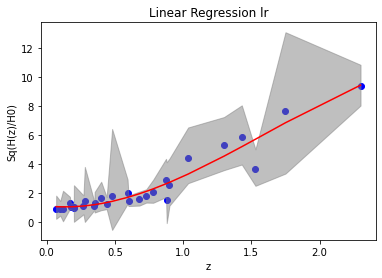

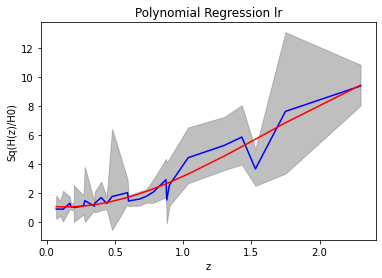

In [417]:
### Training a regression lr to predict the value of H(z) for a given redshift z
# Polynomial regression]
from sklearn.linear_model import LinearRegression

X = df[['a', 'b']]
y = df['hz0']

lr = LinearRegression()
lr.fit(X, y)

# find the coefficient of a and b, and the intercept
coeff_a, coeff_b, intercept = lr.coef_[0], lr.coef_[1], lr.intercept_
print(f'Coefficients of a and b: {coeff_a, coeff_b}')
print(f'Intercept: {intercept}')

X = df['z']
y = df['hz0']
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3)
X = X.values.reshape(-1, 1)
X_poly = poly.fit_transform(X)
lr = LinearRegression()

lr.fit(X_poly, y)
print(f'Coefficients of the polynomial regression lr: {lr.coef_}')
print(f'Intercept: {lr.intercept_}')
# y = c3*x^3 + c2*x^2 + c1*x + c0
c3, c2, c1, c0 = lr.coef_[2], lr.coef_[1], lr.coef_[0], lr.intercept_
print(f'c3, c2, c1, c0: {lr.coef_}, {lr.intercept_}')
print(f'Sq(H(z)/H0) = {c3}*z^3 + {c2}*z^2 + {c1}*z + {c0}')
# Plot the regression lr
plt.scatter(df['z'], df['hz0'], color='blue')
plt.plot(df['z'], lr.predict(X_poly), color='red')
plt.xlabel('z')
plt.ylabel('Sq(H(z)/H0)')
plt.fill_between(df['z'], df['hzl'], df['hzu'], color='gray', alpha=0.5)    
plt.title('Linear Regression lr')
plt.show()


# Plot the polynomial regression lr
plt.plot(df['z'], df['hz0'], color='blue')
plt.plot(df['z'], lr.predict(X_poly), color='red')
plt.xlabel('z')
plt.ylabel('Sq(H(z)/H0)')
plt.fill_between(df['z'], df['hzl'], df['hzu'], color='gray', alpha=0.5)    
plt.title('Polynomial Regression lr')
plt.show()





In [418]:
# # Initialize the parameters with the values of m, k, and l, define loss function and use gradient descent to minimize the loss function
# import torch
# import torch.optim as optim
# import torch.nn as nn

# # Convert the data to tensors
# z = torch.tensor(df['z'].values, dtype=torch.float32)
# hz0 = torch.tensor(df['hz0'].values, dtype=torch.float32)
# e = torch.tensor(df['e'].values, dtype=torch.float32)
# # [ 0.17416501 -0.31063062  1.159686  ] initial values of m, k, and l

# # Define the model
# class Model(nn.Module):
#     def __init__(self):
#         super(Model, self).__init__()
#         self.m = nn.Parameter(torch.tensor(0.17416501, requires_grad=True))
#         self.k = nn.Parameter(torch.tensor(-0.31063062, requires_grad=True))
#         self.l = nn.Parameter(torch.tensor(1.159686, requires_grad=True))

        
#     def forward(self, z):
#         return (self.m*(1+z)**3 + self.k*(1+z)**2 + self.l)
    
# model_0, model_1, model_2 = Model(), Model(), Model()

# # Define the loss function
# def loss_fn_0(y, y_pred, e):
#     return torch.sum(abs(y - y_pred)/e**2)

# def loss_fn_1(y, y_pred, e):
#     loss = torch.zeros(len(y))
#     for i in range(len(y)):
#         if y_pred[i] > df['hz1'][i]:
#             loss[i] = (y_pred[i] - df['hz1'][i])
#         elif y_pred[i] < df['hz-1'][i]:
#             loss[i] = (df['hz-1'][i] - y_pred[i])
#         else:
#             loss[i] = 0
#     return torch.sum(loss)

# def loss_fn_2(y, y_pred, e):
#     loss = torch.zeros(len(y))
#     for i in range(len(y)):
#         if y_pred[i] > df['hz2'][i]:
#             loss[i] = (y_pred[i] - df['hz2'][i])
#         elif y_pred[i] < df['hz-2'][i]:
#             loss[i] = (df['hz-2'][i] - y_pred[i])
#         else:
#             loss[i] = 0
#     return torch.sum(loss)

# # Define the optimizer
# optimizer = optim.Adam([model_0.m, model_0.k, model_0.l], lr=0.01)


# # Train the model
# def train(model, z, hz0, e, loss_fn, optimizer, epochs=1000):
#     for epoch in range(epochs):
#         optimizer.zero_grad()
#         y_pred = model(z)
#         loss = loss_fn(hz0, y_pred, e)
#         loss.backward()
#         optimizer.step()
#         if (epoch+1) % 400 == 0:
#             print('Epoch:', epoch+1, 'Loss:', loss.item())
#     print('Epoch:', epoch+1, 'Loss:', loss.item())
#     print('Best fit values of m, k, and l:', model.m.item(), model.k.item(), model.l.item())
#     print('\n\n')
#     return model

# model_0 = train(model_0, z, hz0, e, loss_fn_0, optimizer, epochs=2000)
# model_1 = train(model_1, z, hz0, e, loss_fn_1, optimizer, epochs=2000)
# model_2 = train(model_2, z, hz0, e, loss_fn_2, optimizer, epochs=2000)

# # Report the best fit values of m, k, and l
# print(f'For loss_0: m = {model_0.m.item()}, k = {model_0.k.item()}, l = {model_0.l.item()}')
# print(f'For loss_1: m = {model_1.m.item()}, k = {model_1.k.item()}, l = {model_1.l.item()}')
# print(f'For loss_2: m = {model_2.m.item()}, k = {model_2.k.item()}, l = {model_2.l.item()}')



In [419]:
# model_0 = train(model_0, z, hz0, e, loss_fn_0, optimizer, epochs=2000)
# print(f'For loss_0: m = {model_0.m.item()}, k = {model_0.k.item()}, l = {model_0.l.item()}')


In [420]:
# # For loss_0: m = -0.018983950838446617, k = 0.14773648977279663, l = 0.8314396739006042
# m_final = model_0.m.item(); k_final = model_0.k.item(); l_final = model_0.l.item()
# # m_final, k_final, l_final = -0.018983950838446617, 0.14773648977279663, 0.8314396739006042  

# # Plot the data 
# plt.plot(df['z'], df['hz0'], 'o', label='data')
# z = np.linspace(0, 2, 100)
# plt.plot(z, model(z, m_final, k_final, l_final), label='best fit model')
# plt.fill_between(df['z'], df['hz-1'], df['hz1'], color='gray', alpha=0.5)
# plt.xlabel('z')
# plt.ylabel('H(z)/H0')
# plt.legend()
# plt.show()

# # Plot the tolerance bands
# plt.plot(df['z'], df['hz0'], 'o', label='data')
# z = np.linspace(0, 2, 100)
# plt.plot(z, model(z, m_final, k_final, l_final), label='best fit model')
# plt.fill_between(df['z'], df['hz-2'], df['hz2'], color='gray', alpha=0.5)
# plt.xlabel('z')
# plt.ylabel('H(z)/H0')
# plt.legend()
# plt.show()


## Inbuilt method


In [421]:

# To find the best fit values of m, k, and l, we can use the least squares method.
from scipy.optimize import curve_fit

popt, pcov = curve_fit(model, df['z'], df['hz0'], sigma=df['e'], absolute_sigma=True)
print(popt)
print(np.sqrt(np.diag(pcov)))
print(f'value of m: {popt[0]} +/- {np.sqrt(pcov[0,0])}')
print(f'value of k: {popt[1]} +/- {np.sqrt(pcov[1,1])}')
print(f'value of l: {popt[2]} +/- {np.sqrt(pcov[2,2])}')

[0.18538385 0.22299174 0.37838579]
[1.76918853 6.22256534 7.52187394]
value of m: 0.18538385075663577 +/- 1.7691885305482016
value of k: 0.22299174063677957 +/- 6.222565339452787
value of l: 0.378385794319299 +/- 7.52187394161087


Best fit values of m, k, and l:[0.17394948 0.25353387 0.39313364]
Loss = 11.919106452171203
value of m: 0.17394948120434472
value of k: 0.25353386991145194
value of l: 0.3931336429818136
Ul loss: 0.0
Loss_0 = 11.919106452171203
Loss_1 = 6.259306828136575
Loss_1_5 = 0.7107665132525284
 Loss_2 = 1.2001290815751877


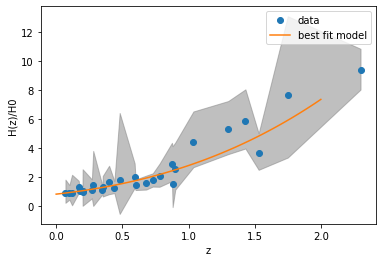

Best fit values of m, k, and l:[0.09632667 0.54621316 0.06278698]
Loss = 5.993845530863082
value of m: 0.09632666915414806
value of k: 0.5462131578102738
value of l: 0.06278698153679108
Ul loss: 0.11677541792233459
Loss_0 = 11.795074876481484
Loss_1 = 5.993845530863082
Loss_1_5 = 0.7039364249685708
 Loss_2 = 1.1459662408581206


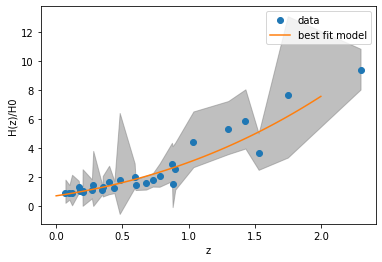

Best fit values of m, k, and l:[ 0.01897131  0.73786671 -0.13693106]
Loss = 0.5745534753686413
value of m: 0.01897130724397251
value of k: 0.7378667118294809
value of l: -0.13693106084993298
Ul loss: 0.0
Loss_0 = 13.393514248734519
Loss_1 = 7.301801733173738
Loss_1_5 = 0.5745534753686413
 Loss_2 = 1.2017993522164119


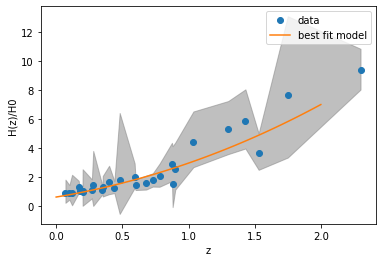

Best fit values of m, k, and l:[0.20492585 0.21795869 0.38587462]
Loss = 1.032780384428395
value of m: 0.20492585020385484
value of k: 0.21795868943008592
value of l: 0.3858746182510864
Ul loss: 0.07434435948139573
Loss_0 = 12.089478485656812
Loss_1 = 6.398719932117785
Loss_1_5 = 0.700955255970307
 Loss_2 = 1.032780384428395


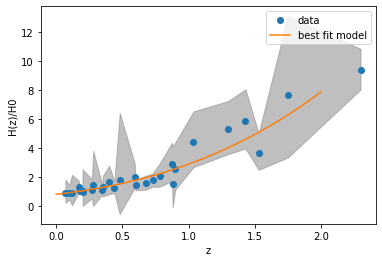

In [422]:
from scipy.optimize import minimize
def performance_of_loss(loss, popt):
    result = minimize(loss, popt)
    print(f'Best fit values of m, k, and l:{result.x}')
    print(f'Loss = {loss(result.x)}')

    # print the best fit values of m, k, and l
    print(f'value of m: {result.x[0]}')
    print(f'value of k: {result.x[1]}')
    print(f'value of l: {result.x[2]}')


    print(f'Ul loss: {loss_ul(result.x)}')
    print(f'Loss_0 = {loss_0(result.x)}')
    print(f'Loss_1 = {loss_1(result.x)}')
    print(f'Loss_1_5 = {loss_1_5(result.x)}')
    print(f' Loss_2 = {loss_2(result.x)}')
    plot_tolerances(*result.x)
'''
    # plot the data and the best fit model
    plt.errorbar(df['z'], df['hz0'], yerr=df['e'], fmt='o', label='data')
    z = np.linspace(0, 2, 100)
    plt.plot(z, model(z, *result.x), label='best fit model')
    plt.xlabel('z')
    plt.ylabel('H(z)/H0')
    plt.legend()
    plt.show()

    # plot the residuals
    plt.errorbar(df['z'], model(df['z'], *result.x) - df['hz0'], yerr=df['e'], fmt='o')
    plt.axhline(0, color='black', lw=1)
    plt.xlabel('z')
    plt.ylabel('residuals')
    plt.show()
'''
performance_of_loss(loss_0, popt)
performance_of_loss(loss_1, popt)
performance_of_loss(loss_1_5, popt)
performance_of_loss(loss_2, popt)

Now, final submisttion plotting: 


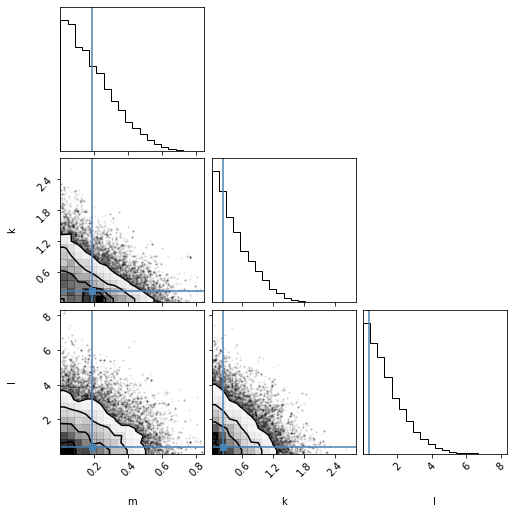

<Figure size 720x720 with 0 Axes>

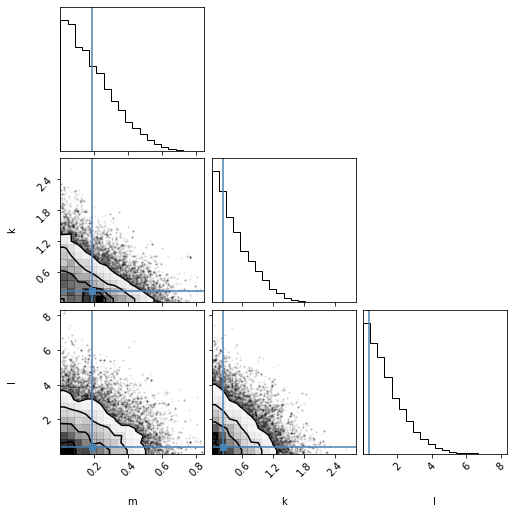

<Figure size 720x720 with 0 Axes>

1 Sigma, 2 Sigma, 3 Sigma for m: (0.15824172408706083, 0.17829845586277293, 0.11261075024284216)
1 Sigma, 2 Sigma, 3 Sigma for k: (0.3511271557856731, 0.46390146934545606, 0.25703495835457907)
1 Sigma, 2 Sigma, 3 Sigma for l: (1.093671637882687, 1.352129901556934, 0.7853982040497265)


In [427]:
# Best fit values of m, k, and l:[0.17394948 0.25353387 0.39313364]
# plot 1 and 2D marginalized probability distributions for all three parameters and report uncertainty corresponding to 1,2 and 3 


def model(z, m, k, l):
    return (m*(1+z)**3 + k*(1+z)**2 + l)

m_final, k_final, l_final = 0.17394948, 0.25353387, 0.39313364

# To plot 1D marginalized probability distributions for all three parameters, we can use the corner module
# !pip install corner
import corner
ndim, nwalkers = 3, 100
pos = [popt + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

def lnprob(p):
    if p[0] > 0 and p[1] > 0 and p[2] > 0:
        return -0.5 * np.sum((model(df['z'], *p) - df['hz0'])**2 / df['e']**2)
    return -np.inf

# !pip install emcee
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
sampler.run_mcmc(pos, 500)

samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=['m', 'k', 'l'], truths=popt)
plt.figure(figsize=(10, 10))
plt.show()

# To plot 2D marginalized probability distributions for all three parameters, we can use the corner module
fig = corner.corner(samples, labels=['m', 'k', 'l'], truths=popt)
plt.figure(figsize=(10, 10))    
plt.show()

# Report the uncertainty corresponding to 1, 2, and 3 sigma
m_mcmc, k_mcmc, l_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))
print(f'1 Sigma, 2 Sigma, 3 Sigma for m: {m_mcmc}')
print(f'1 Sigma, 2 Sigma, 3 Sigma for k: {k_mcmc}')
print(f'1 Sigma, 2 Sigma, 3 Sigma for l: {l_mcmc}')



In [423]:
# # To find the value by definig=ng a loss function and minimizing it
# def loss_1(params):
#     m, k, l = params
#     # return np.sum(((model(df['z'], m, k, l) - df['hz0'])/df['e'])**2)
#     # if value lies between the error bars, the loss is 0
#     # if value is more than the upper error bar, the loss is (value - upper error bar), else (lower error bar - value)
#     v = model(df['z'], m, k, l)
#     loss = np.zeros(len(v))

#     for i in range(len(v)):
#         if v[i] > df['hz1'][i]:
#             loss[i] = (v[i] - df['hz1'][i])
#         elif v[i] < df['hz-1'][i]:
#             loss[i] = (df['hz-1'][i] - v[i])
#         else:
#             loss[i] = 0
#     return np.sum(loss)

    
# performance_of_loss(loss, popt)

In [424]:
# # To find the value by definig=ng a loss function and minimizing it
# def loss(params):
#     m, k, l = params
#     # return np.sum(((model(df['z'], m, k, l) - df['hz0'])/df['e'])**2)
#     # if value lies between the error bars, the loss is 0
#     # if value is more than the upper error bar, the loss is (value - upper error bar), else (lower error bar - value)
#     v = model(df['z'], m, k, l)
#     loss = np.zeros(len(v))

#     for i in range(len(v)):
#         loss[i] = abs(v[i] - df['hz0'][i])
#     return np.sum(loss)
    
# performance_of_loss(loss, popt)



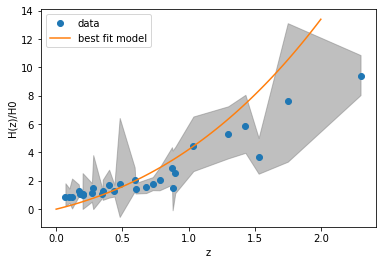

In [425]:
plot_tolerances(0.3, 0.7, -1)